In [1]:
import numpy as np
from python.analysis import Plots
Plots.plt.style.use("default")
Plots.plt.style.use("ggplot")

Measueing pi:

The definition for the area of a circle is

$$
A_{c} = \pi r_{c}^{2}
$$

so by measuring $r_{c}$ and $A_{c}$ you can compute $\pi$. to measure the area one would use the formula, but instead we can look at the problem in a different way. Let us compare the ratio of the square  with $r_{s}$ to a circe:

$$
R = \frac{\pi r_{c}^{2}}{r_{s}^2}
$$

and when $r_{s}$ = $r_{c}$, $R = \pi$. To indirectly measure this ratio we can do the following:
 - create a target with a circle overlapping a sqaure with $r_{s} = 2 r_{c}$.
 - throw darts randomly at the target
 - count the number of darts which are in the circle and count the number in the square, and the ratio of these numbers are directly proportional to the $R$.

Note now because $r_{s} = 2 r_{c}$ the equation is modified:

$$
R = \frac{4\pi r_{c}^{2}}{r_{s}^2}
$$


In [2]:
def count_in_circle(throws, r_c):
    r = (throws[0]**2 + throws[1]**2)**2
    return sum(r < r_c)


def count_in_square(throws, r_s):
    return sum((throws[0] < r_s) & (throws[1] < r_s))


def R(throws, r_s, r_c):
    return 4 * count_in_circle(throws, r_c)/count_in_square(throws, r_s)


def sigma_r_stat(throws, r_s, r_c):
    n_c = count_in_circle(throws, r_c)
    n_s = count_in_square(throws, r_s)
    return 4* n_c/n_s * (1/n_c + 1/n_s)**0.5

In [3]:
def throw_bias(x, y):
    return [[x], [y]]

In [4]:
r_s = 2
r_c = 1
n_throws = 1000

bx = -0.75
by = 0.75

throws = r_s * (np.random.random([2, n_throws]) - 0.5) + throw_bias(bx, by) # where did the dart land

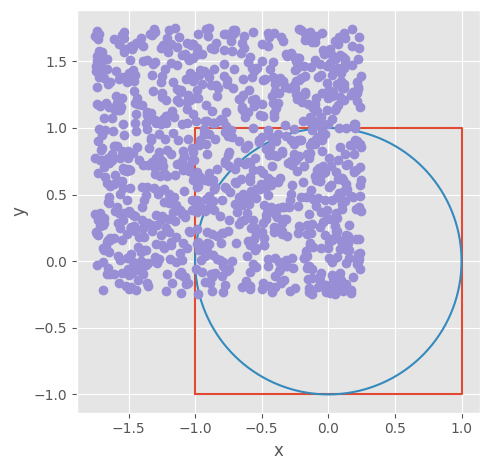

In [5]:
def visualise():
    Plots.Plot(np.array([-0.5, 0.5, 0.5, -0.5, -0.5])*r_s, np.array([-0.5, -0.5, 0.5, 0.5, -0.5])*r_s, xlabel = "x", ylabel = "y")
    theta = np.linspace(0, 2* np.pi, 1000)
    Plots.Plot(r_c * np.sin(theta), r_c * np.cos(theta), newFigure = False)
    Plots.Plot(throws[0], throws[1], marker = "o", linestyle = "", newFigure = False)
    Plots.plt.gca().set_aspect('equal')
    return

visualise()

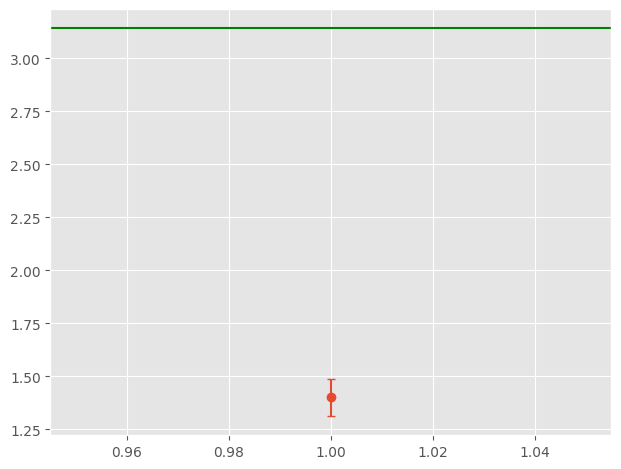

In [6]:
r = R(throws, r_s, r_c)
sigma_r = sigma_r_stat(throws, r_s, r_c)

Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")

# Estimate bias in the throws

In [7]:
def estimate_bias(x):
    return np.mean(x), np.std(x)/(len(x - 1))**0.5

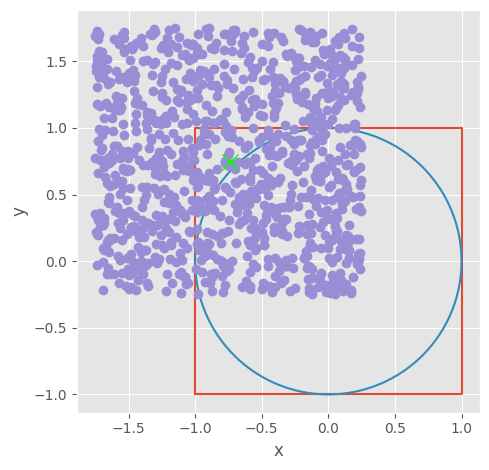

In [8]:
est_bias_x  = estimate_bias(throws[0])
est_bias_y  = estimate_bias(throws[1])
visualise()
Plots.Plot(est_bias_x[0], est_bias_y[0], xerr = est_bias_x[1], yerr = est_bias_y[1], newFigure = False, marker = "x", color = "lime", markersize = 12)

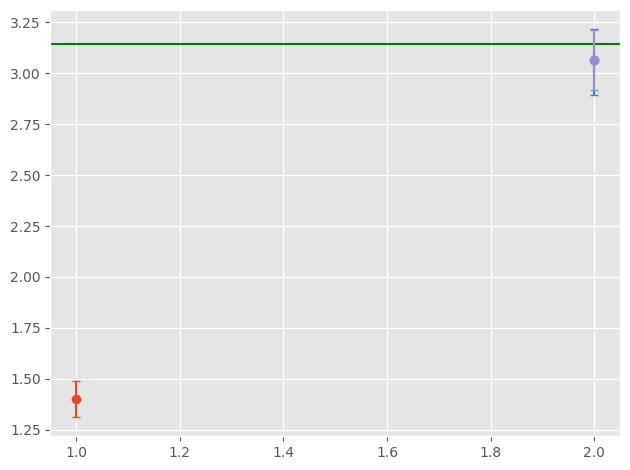

In [9]:
bias_corrected_r = R(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c)
sigma_bias_corrected_r_stat = sigma_r_stat(throws - throw_bias(est_bias_x[0], est_bias_y[0]), r_s, r_c) # this sigma will change based on the upper and lower bounds as well...
bias_corrected_r_upper = R(throws - throw_bias(est_bias_x[0] + est_bias_x[1], est_bias_y[0] + est_bias_y[1]), r_s, r_c)
bias_corrected_r_lower = R(throws - throw_bias(est_bias_x[0] - est_bias_x[1], est_bias_y[0] - est_bias_y[1]), r_s, r_c)


Plots.Plot(1, r, yerr = sigma_r, marker = "o")
Plots.plt.axhline(np.pi, color = "green")
Plots.Plot(2, bias_corrected_r, yerr = [ [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_lower)], [sigma_bias_corrected_r_stat + abs(bias_corrected_r - bias_corrected_r_upper)]], marker = "o", newFigure = False)
Plots.Plot(2, bias_corrected_r, yerr = sigma_bias_corrected_r_stat, marker = "o", newFigure = False)


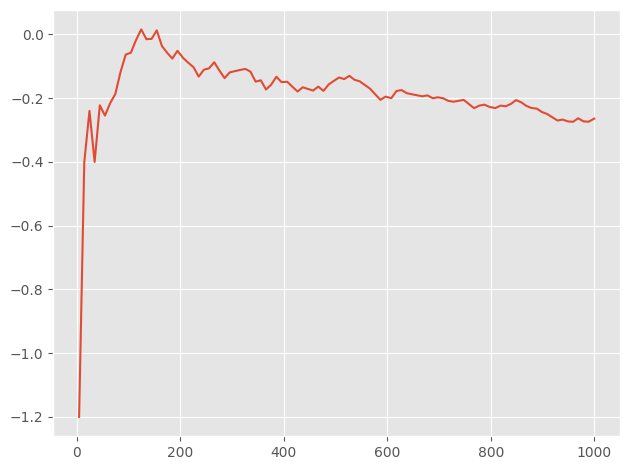

In [10]:
corrected_throws = throws - throw_bias(est_bias_x[0], est_bias_y[0])
bias_corrected_r = R(corrected_throws[:, 0:10], r_s, r_c)

n = np.linspace(5, len(corrected_throws[0]), 100, dtype = int)
out = []
for i in n:
    out.append(abs(bias_corrected_r) - R(corrected_throws[:, 0:i], r_s, r_c))

Plots.Plot(n, out)

# Fischer discriminant

In [11]:
class Fischer:
    def __init__(self, x1, x2):
        self.x1 = x1
        self.x2 = x2

    def Run(self, c1, cutsom_offset : float = 0):
        mu1 = np.array([np.mean(self.x1[c1]), np.mean(self.x2[c1])])
        mu2 = np.array([np.mean(self.x1[~c1]), np.mean(self.x2[~c1])])

        cov1 = np.cov([self.x1[c1], self.x2[c1]])
        cov2 = np.cov([self.x1[~c1], self.x2[~c1]])

        w = np.matmul(np.linalg.inv(cov1 + cov2), (mu1 - mu2))

        f = (w[0] * self.x1) + (w[1] * self.x2)
        w0 = np.median(f) + cutsom_offset
        f -= w0
        f_efficiency = sum((f > 0) == c1) / len(c1)

        print(f"{w=}")
        print(f"{w0=}")
        print(f"{f_efficiency=}")

        x = np.linspace(np.min(self.x1), np.max(self.x1), 10)
        Plots.Plot(x, 0.5 + 2 * x, color = "black", linestyle = "--", label = "exact")

        Plots.Plot(self.x1[c1], self.x2[c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, xlabel = "x1", ylabel = "x2", alpha = 0.5, label = "A")
        Plots.Plot(self.x1[~c1], self.x2[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3, alpha = 0.5, label = "B")

        Plots.Plot(mu1[0], mu1[1], newFigure = False, marker = "X", linestyle = "", color = "C0", markersize = 12, label = "$\mu_{A}$")
        Plots.Plot(mu2[0], mu2[1], newFigure = False, marker = "X", linestyle = "", color = "C1", markersize = 12, label = "$\mu_{B}$")

        Plots.Plot(self.x1[c1], f[c1], marker = "o", linestyle = "", xlabel = "x1", ylabel = "F", markersize = 3)
        Plots.Plot(self.x1[~c1], f[~c1], newFigure = False, marker = "o", linestyle = "", markersize = 3)
        Plots.plt.axhline(0, label = "Fischer cut", color = "black", linestyle = "--")
        return

In [12]:
n = int(1E4)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 3, n)

w=array([ 1.25205094, -0.62119287])
w0=0.030460183391668283
f_efficiency=0.9344


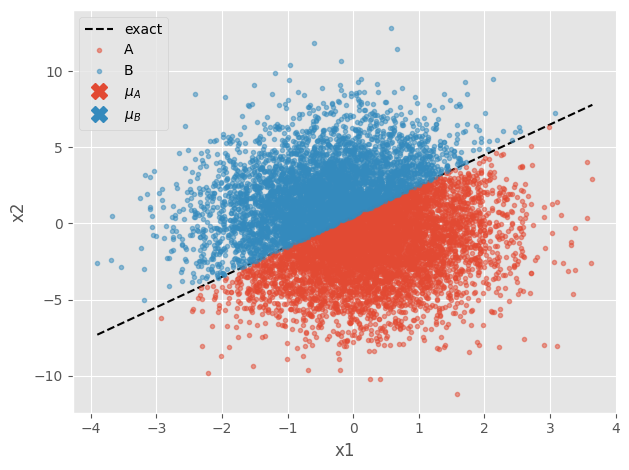

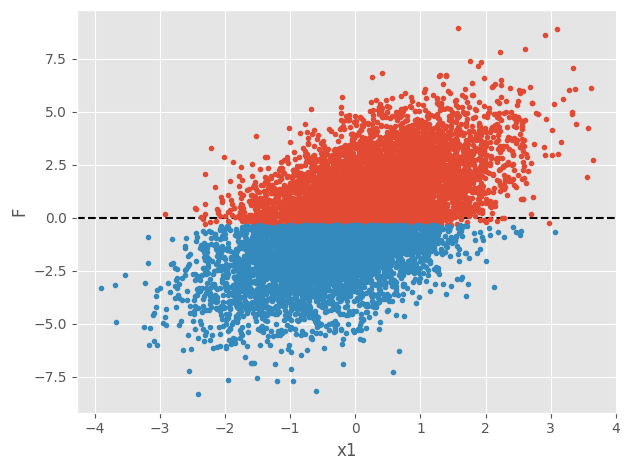

In [13]:
c1 = (-2 * x1 + x2) < 0.5 #* use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

w=array([1.27114477, 0.33625633])
w0=-0.029149551577231814
f_efficiency=0.6293


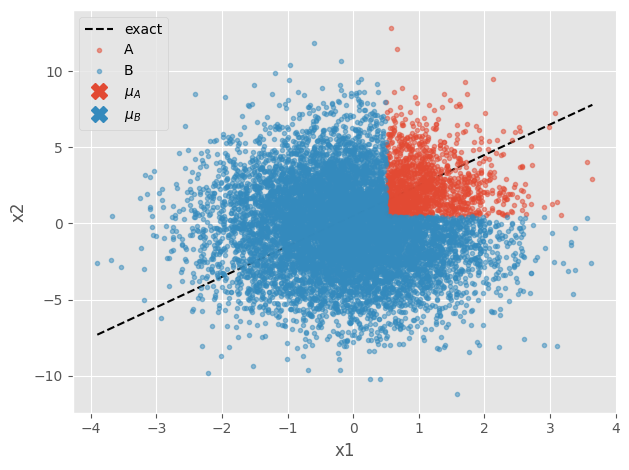

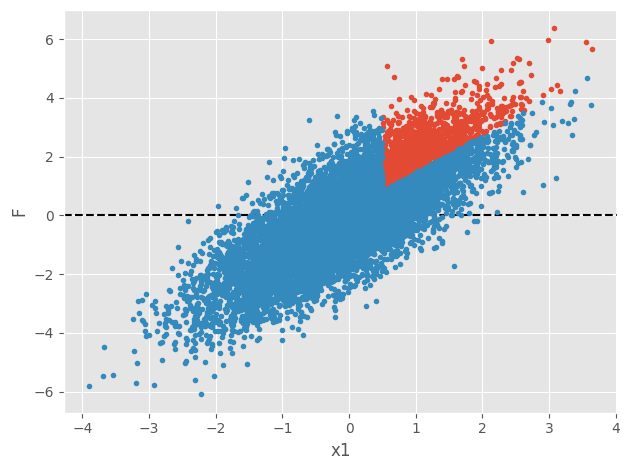

In [14]:
c1 = (x1 > 0.5) & (x2 > 0.5) #! don't use fischer discriminant for this case!
fischer = Fischer(x1, x2)
fischer.Run(c1)

# ABCD background subtraction

$$
N^{b}_{D} = N^{b}_{B}\frac{N^{b}_{C}}{N^{b}_{A}}
$$

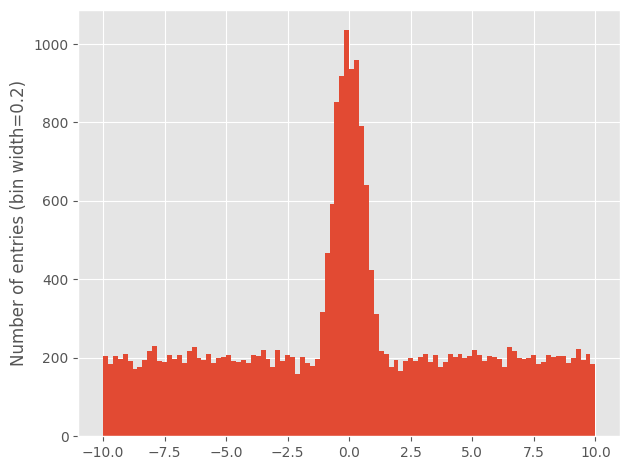

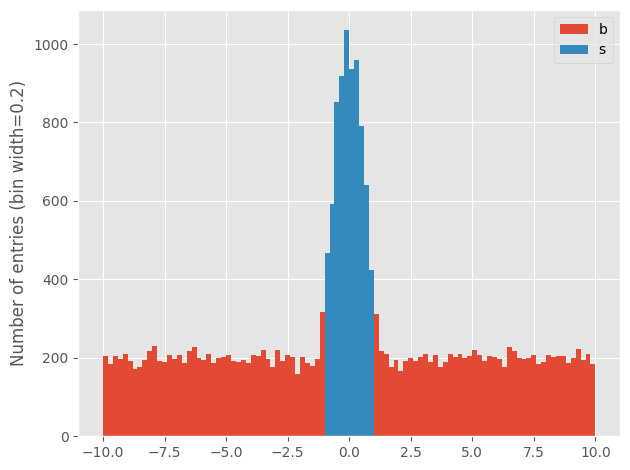

In [15]:
n = int(1E5)

def g(x):
    return np.exp(-x**2)

def u(x):
    return [0.2]*len(x)

x = np.random.uniform(-10, 10, n)
p = np.random.random(n)
a = (p < g(x)) | (p < u(x))
d = x[a]


q1, q2 = np.random.randint(0, 2, [len(d), 2], dtype = bool).T # tagging events

def regions():
    return {"A" : (q1 == 0) & (q2 == 0), "B" : (q1 == 0) & (q2 == 1), "C" : (q1 == 1) & (q2 == 0), "D" : (q1 == 1) & (q2 == 1)}


s = abs(d) < 1
Plots.PlotHist(d)
Plots.PlotHist([d[~s], d[s]], label = ["b", "s"], stacked = True)
r = regions()

0 A
[ 0.48482628  0.34446126 -0.44649947 ...  0.21619913 -0.31496064
  0.68179428]
1 B
[-0.78006616 -0.28983183  0.08616165 ...  0.39950184 -0.2928465
 -0.19843496]
2 C
[-0.85105047  0.0454066  -0.28176281 ...  0.36709506 -0.89630207
  0.92535641]
3 D
[ 0.06469046  0.35519065  0.26357262 ... -0.7385379   0.09264375
  0.73337774]


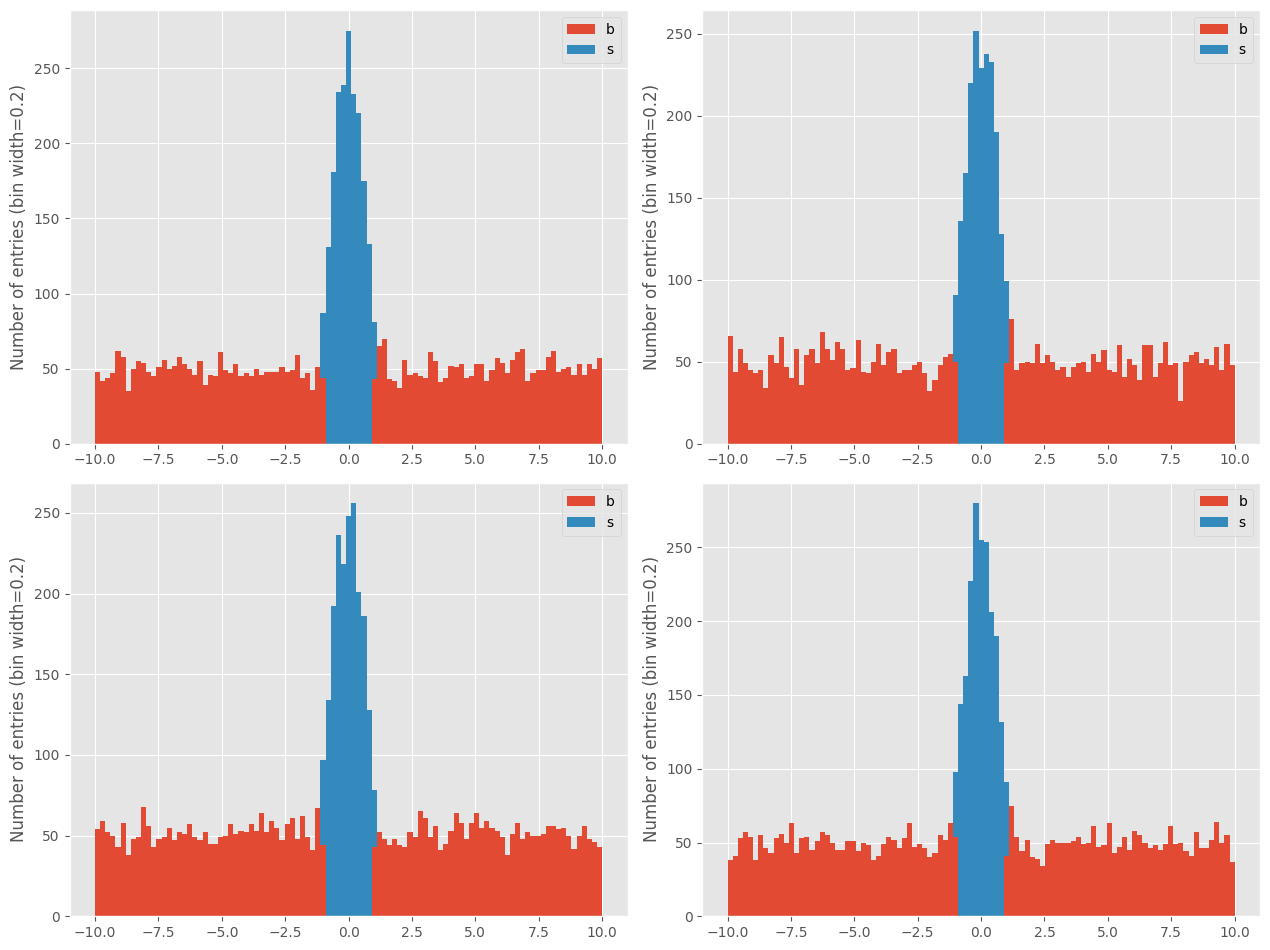

In [16]:
bins = np.linspace(-10, 10, 100) # fix the binning

for i, j in Plots.IterMultiPlot(r):
    print(i, j)
    print(d[r[j] & s])
    Plots.PlotHist([d[r[j] & ~s], d[r[j] & s]], label = ["b", "s"], bins = bins, stacked = True, newFigure = False)


# estimate backgrounds

{'A': (48.96052631578947, 1.0162609123254671), 'B': (49.0921052631579, 1.2247703159653265), 'C': (50.81578947368421, 1.0963592903077606), 'D': (50.952354347303356, 1.9856739290522063)}


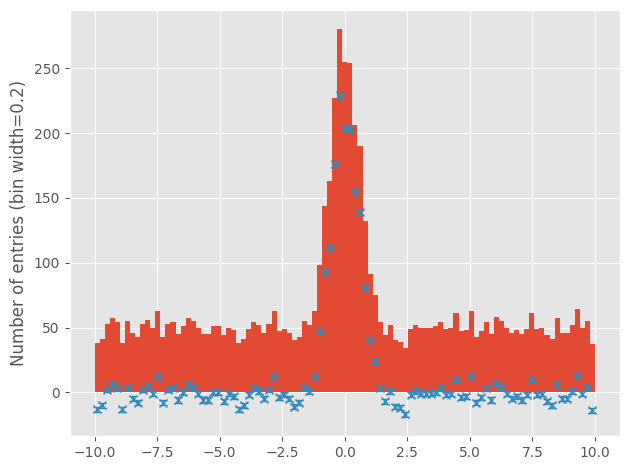

In [18]:
def estimate_background(data):
    background = abs(data) > 2.5
    counts = np.histogram(data[background], bins)[0]
    counts = counts[counts != 0]
    return np.mean(counts), np.std(counts) / np.sqrt(len(counts)-1) 


def ABCD_method(data, reg):
    n_b = {i : estimate_background(data[reg[i]]) for i in ["A", "B", "C"]}

    n_D = (n_b["C"][0]/n_b["A"][0]) * n_b["B"][0] # ABCD subtraction

    n_D_e = n_D * sum([(n_b[i][1]/n_b[i][0])**2 for i in ["A", "B", "C"]])**0.5
    n_b["D"] = (n_D, n_D_e)
    print(n_b)
    return n_b["D"]

n_background = ABCD_method(d, r)
signal_data_hist = np.histogram(d[r["D"]], bins = bins)

centers = (signal_data_hist[1][1:] + signal_data_hist[1][:-1]) / 2

Plots.PlotHist(d[r["D"]], bins = bins)
Plots.Plot(centers, signal_data_hist[0] - n_background[0], yerr = n_background[1], newFigure = False, marker = "x", linestyle = "")

# Plots.plt.hist(signal_data_hist[1][:-1], bins = signal_data_hist[1], weights = signal_data_hist[0] - n_background[0])


# pyhf

In [100]:
import json
import pyhf
import numpy as np
from python.analysis import Plots
from python.analysis.cross_section import SetPlotStyle
from rich import print
SetPlotStyle(True, 100)
pyhf.set_backend(backend = "numpy", custom_optimizer = "minuit")


def CreateDataSet(seed : int, n_regions : int, n_background : int, n_data : int, bins : list):
    rng = np.random.default_rng(seed)
    mu =    [0, 0.5, 1, 2]
    sigma = [1, 0.5, 3, 1.4]
    # mu = rng.random()
    # sigma = rng.random()

    sample_fractions = rng.random(size = [n_regions, n_background + 1])
    sample_fractions = sample_fractions / np.sum(sample_fractions, axis = 1)[:, np.newaxis]
   
    output = {}
    for i in range(n_regions):
        output[f"region_{i}"] = [np.random.normal(mu[j], sigma[j], int(n_data * sample_fractions[i][j])) for j in range(n_background + 1)]
        output[f"region_{i}_binned"] = [np.histogram(i, bins = bins)[0] for i in output[f"region_{i}"]]
        output[f"region_{i}_combined"] = np.sum(output[f"region_{i}_binned"], axis = 0)

    return output


def PrintModelSpecs(model):
    print(f"  channels: {model.config.channels}")
    print(f"     nbins: {model.config.channel_nbins}")
    print(f"   samples: {model.config.samples}")
    print(f" modifiers: {model.config.modifiers}")
    print(f"parameters: {model.config.parameters}")
    print(f"  nauxdata: {model.config.nauxdata}")
    print(f"   auxdata: {model.config.auxdata}")


def GenerateObservations(data, n_regions, model, verbose : bool = True):
    if verbose is True: print(f"{model.config.suggested_init()=}")
    observations = np.concatenate([data[f"region_{n}_combined"] for n in range(n_regions)] + [model.config.auxdata])
    if verbose is True: print(f"{model.logpdf(pars=model.config.suggested_init(), data=observations)=}")
    return observations

def Fit(observations, model, verbose : bool = True):
    result = pyhf.infer.mle.fit(data=observations, pdf=model, return_uncertainties = True)
    if verbose is True: print(f"{model.config.poi_index=}")
    if verbose is True: print(f"{result=}")
    return result

def PlotSignal(data, n_regions, result, model):
    mu = result[model.config.poi_index]
    print(f"{mu=}")
    centers = (bins[1:] + bins[:-1])/2

    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, newFigure = False)
        Plots.Plot(centers, mu[0] * model.spec["channels"][n]["samples"][0]["data"], yerr = mu[1] * model.spec["channels"][n]["samples"][0]["data"], color = "black", marker = "x", linestyle = "", newFigure = False)


def MakePlots(data, result, n_regions, n_background, model):
    config_order = {"mu" : 0}
    config_order.update({f"bkg_{i}" : i + 1 for i in range(n_background)})
    for n in Plots.MultiPlot(n_regions):
        Plots.PlotHist(data[f"region_{n}"], stacked = True, bins = bins, label = [f"mc:{i}" for i in config_order], newFigure = False)
        counts = np.zeros(len(bins) - 1)
        for p in config_order:
            model_index = model.config.par_map[p]["slice"].start
            config_index = config_order[p]
            counts = counts + model.spec["channels"][n]["samples"][config_index]["data"]
            Plots.Plot(centers, result[model_index][0] * counts, yerr = result[model_index][1] * counts, label = f"data:{p}", marker = "x", linestyle = "", newFigure = False)

# simple example

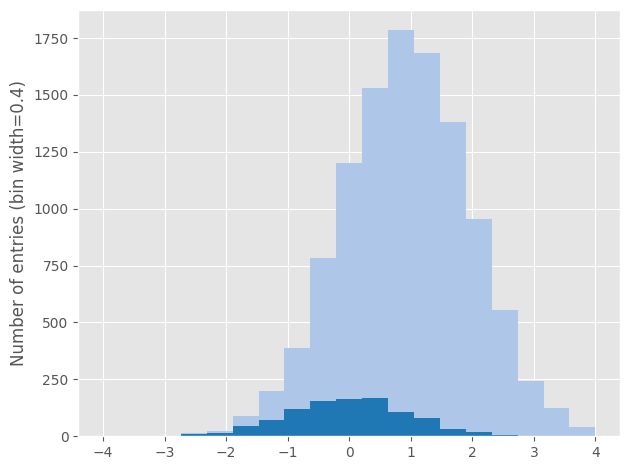

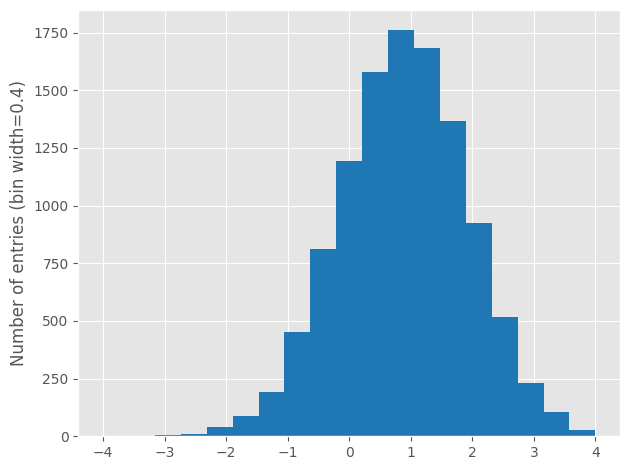

In [2]:
data = [np.random.normal(0, 1, 1000), np.random.normal(1, 1, 10000)]
observed = [np.random.normal(0, 1, 1000), np.random.normal(1, 1, 10000)] # in reality Data would be normalised to MC, so total counts will be equal. 

norm = len(np.concatenate(data))/len(np.concatenate(observed))

bins = np.linspace(-4, 4, 20)

Plots.PlotHist(data, stacked = True, bins = bins)
Plots.PlotHist(np.concatenate(observed), bins = bins)

data_binned = [np.histogram(data[0], bins = bins)[0], np.histogram(data[1], bins = bins)[0]]
observed_binned_cheat = [np.histogram(observed[0], bins = bins)[0], np.histogram(observed[1], bins = bins)[0]]
observed_binned = np.histogram(np.concatenate(observed), bins = bins)[0]

In [3]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=data_binned[0], bkg=data_binned[1], bkg_uncertainty=np.sqrt(data_binned[1])
)
print(model.spec)

{
    'channels': [
        {
            'name': 'singlechannel',
            'samples': [
                {
                    'name': 'signal',
                    'data': array([  0,   1,   0,  12,  14,  46,  70, 122, 156, 164, 170, 107,  81,
        30,  19,   6,   2,   0,   0]),
                    'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]
                },
                {
                    'name': 'background',
                    'data': array([   0,    0,    0,    1,    9,   43,  127,  264,  627, 1037, 1360,
       1677, 1604, 1350,  934,  550,  239,  124,   41]),
                    'modifiers': [
                        {
                            'name': 'uncorr_bkguncrt',
                            'type': 'shapesys',
                            'data': array([ 0.        ,  0.        ,  0.        ,  1.        ,  3.        ,
        6.55743852, 11.26942767, 16.24807681, 25.03996805, 32.20248438,
       36.87817783, 40.95119046, 40.04996879, 36.74234614, 30.56141358,
       23.4520788 , 15.45962483, 11.13552873,  6.40312424])
                        }
                    ]
                }
            ]
        }
    ]
}

In [4]:
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"  nauxdata: {model.config.nauxdata}")
print(f"   auxdata: {model.config.auxdata}")

channels: ['singlechannel']

nbins: {'singlechannel': 19}

samples: ['background', 'signal']

modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]

parameters: ['mu', 'uncorr_bkguncrt']

nauxdata: 19

auxdata: [1.0, 1.0, 1.0, 1.0, 9.0, 43.00000000000001, 127.00000000000001, 263.99999999999994, 626.9999999999999,
1037.0000000000002, 1360.0, 1676.9999999999998, 1603.9999999999998, 1349.9999999999998, 933.9999999999999, 
549.9999999999999, 239.0, 124.00000000000001, 41.0]

In [5]:
print(model.config.suggested_init())
observations = np.concatenate([observed_binned, model.config.auxdata])
print(model.logpdf(pars=model.config.suggested_init(), data=observations))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[-inf]

In [6]:
result = pyhf.infer.mle.fit(data=observations, pdf=model)
print(model.config.poi_index)
print(result)

     corr: None
      fun: inf
 hess_inv: None
  message: 'Optimization failed. Estimated distance to minimum too large.'
   minuit: <FMin algorithm='Migrad' edm=nan edm_goal=0.0002 errordef=1.0 fval=inf has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=False hesse_failed=False is_above_max_edm=True is_valid=False nfcn=1353 ngrad=0 reduced_chi2=nan time=0.8489017530000069>
(Param(number=0, name='mu', value=1.0000000000000002, error=nan, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=10.0), Param(number=1, name='uncorr_bkguncrt[0]', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=1e-10, upper_limit=10.0), Param(number=2, name='uncorr_bkguncrt[1]', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=1e-10, upper_limit=10.0), Param(number=3, name='uncorr_bkguncrt[2]', value=1.0, erro

FailedMinimization: Optimization failed. Estimated distance to minimum too large.

1.0667290614652036

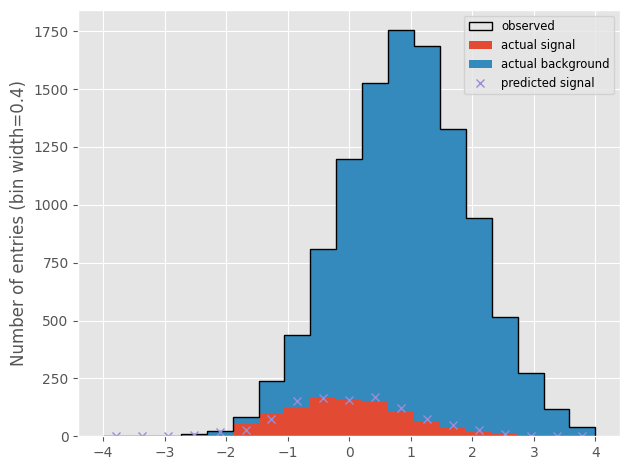

In [ ]:
mu = result[model.config.poi_index]
print(mu)
centers = (bins[1:] + bins[:-1])/2

Plots.PlotHist(np.concatenate(observed), bins, histtype = "step", color = "black", label = "observed")
Plots.PlotHist(observed, bins, stacked = True, newFigure = False, label = ["actual signal", "actual background"])
Plots.Plot(centers, mu * data_binned[0], newFigure = False, linestyle = "", marker = "x", label = "predicted signal")


# 2 channels

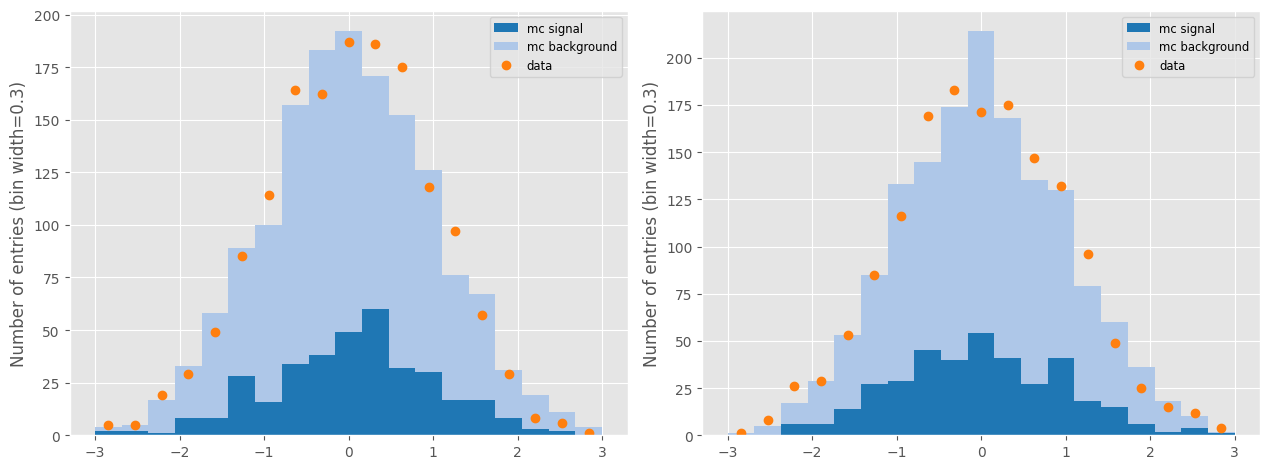

In [ ]:
def channel(num : int, signal_data : np.array, background_data : np.array, background_error : np.array):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [{'name': "mu", 'type': 'normfactor', 'data': None}]
            },
            {
                "name" : f"background_{num}",
                "data" : background_data,
                "modifiers" : [{'name': f"bkg_{num}", 'type': 'staterror', 'data': background_error}]
            },
            
        ],
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 2
mc = CreateDataSet(250, n_regions, 1, 1500, bins)
data = CreateDataSet(250, n_regions, 1, 1500, bins)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal", "mc background"], newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"], marker = "o", linestyle = "", label = "data", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1], np.sqrt(mc[f"region_{n}_binned"][1]))
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)

In [ ]:
PrintModelSpecs(model)

channels: ['channel_0', 'channel_1']

nbins: {'channel_0': 19, 'channel_1': 19}

samples: ['background_0', 'background_1', 'signal']

modifiers: [('bkg_0', 'staterror'), ('bkg_1', 'staterror'), ('mu', 'normfactor')]

parameters: ['bkg_0', 'bkg_1', 'mu']

nauxdata: 38

auxdata: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
observations = GenerateObservations(data, n_regions, model)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-108.84835742])

model.config.poi_index=0

result=array([[1.0184034 , 0.0958624 ],
       [1.15190876, 0.56942125],
       [0.99541281, 0.45605768],
       [1.05836428, 0.17926034],
       [0.92634479, 0.15211998],
       [0.91182419, 0.10423533],
       [0.9696274 , 0.10049411],
       [1.07200458, 0.0807146 ],
       [1.02249287, 0.06849619],
       [0.931941  , 0.06324773],
       [0.98229677, 0.06494387],
       [1.04817392, 0.07655801],
       [1.07943781, 0.06899523],
       [0.96091369, 0.07817894],
       [1.14385999, 0.09790183],
       [0.90852469, 0.1085461 ],
       [0.95965336, 0.15905809],
       [0.61804809, 0.18820106],
       [0.71114446, 0.25112645],
       [0.50000002, 0.35200456],
       [1.        , 0.70057761],
       [1.26491106, 0.31575096],
       [1.28455343, 0.23218613],
       [0.99787917, 0.15618124],
       [0.99720415, 0.12251309],
       [0.99653258, 0.10294581],
       [0.92363092, 0.07470759],
       [1.0908993 , 0.07864024],
       [1.0264629 , 0.06608493],
       [0.87613513, 0.06180383],
       [1.02092905, 0.06826297],
       [1.04629093, 0.07242194],
       [1.00565471, 0.08366142],
       [1.11321027, 0.09655993],
       [0.88747882, 0.11431412],
       [0.81669376, 0.13627831],
       [0.90668555, 0.1824453 ],
       [1.11491841, 0.32097387],
       [1.55460709, 0.78410544]])

mu=array([1.0184034, 0.0958624])

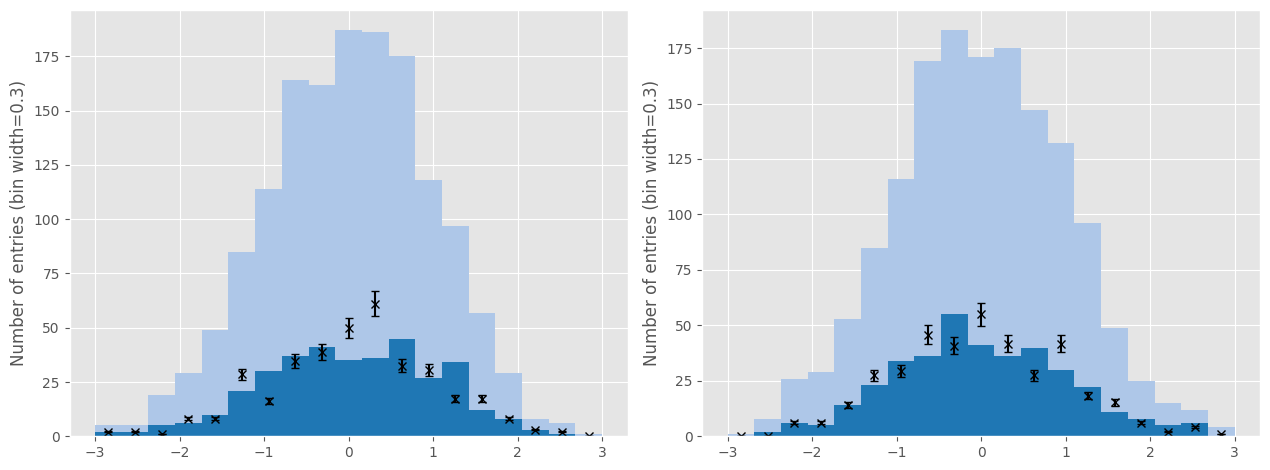

In [ ]:
result = Fit(observations, model)
PlotSignal(data, n_regions, result, model)

# background strength

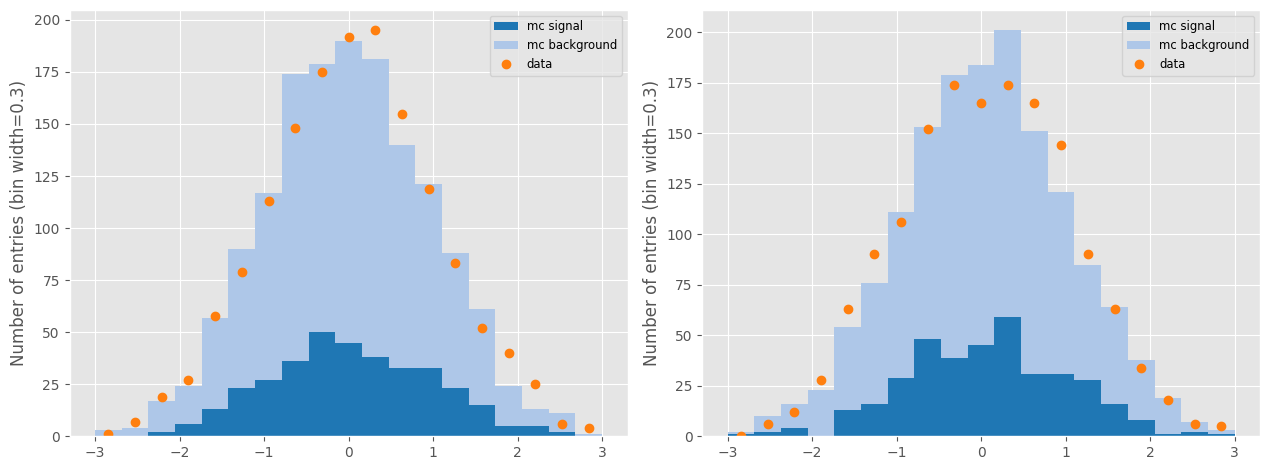

In [ ]:
def channel(num : int, signal_data : np.array, background_data : np.array):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [{'name': "mu", 'type': 'normfactor', 'data': None}]
            },
            {
                "name" : f"background_{num}",
                "data" : background_data,
                "modifiers" : [{'name': f"bkg_{num}", 'type': 'normfactor', 'data': None}]
            },
            
        ],
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 2
mc = CreateDataSet(250, n_regions, 1, 1500, bins)
data = CreateDataSet(250, n_regions, 1, 1500, bins)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal", "mc background"], newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"], marker = "o", linestyle = "", label = "data", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1])
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)

In [ ]:
PrintModelSpecs(model)

channels: ['channel_0', 'channel_1']

nbins: {'channel_0': 19, 'channel_1': 19}

samples: ['background_0', 'background_1', 'signal']

modifiers: [('bkg_0', 'normfactor'), ('bkg_1', 'normfactor'), ('mu', 'normfactor')]

parameters: ['bkg_0', 'bkg_1', 'mu']

nauxdata: 0

auxdata: []

In [ ]:
observations = GenerateObservations(data, n_regions, model)

model.config.suggested_init()=[1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-136.91576467])

model.config.poi_index=1

result=array([[1.0916695 , 0.09664314],
       [0.71243318, 0.29009088],
       [1.09484577, 0.10101483]])

<Figure size 640x480 with 0 Axes>

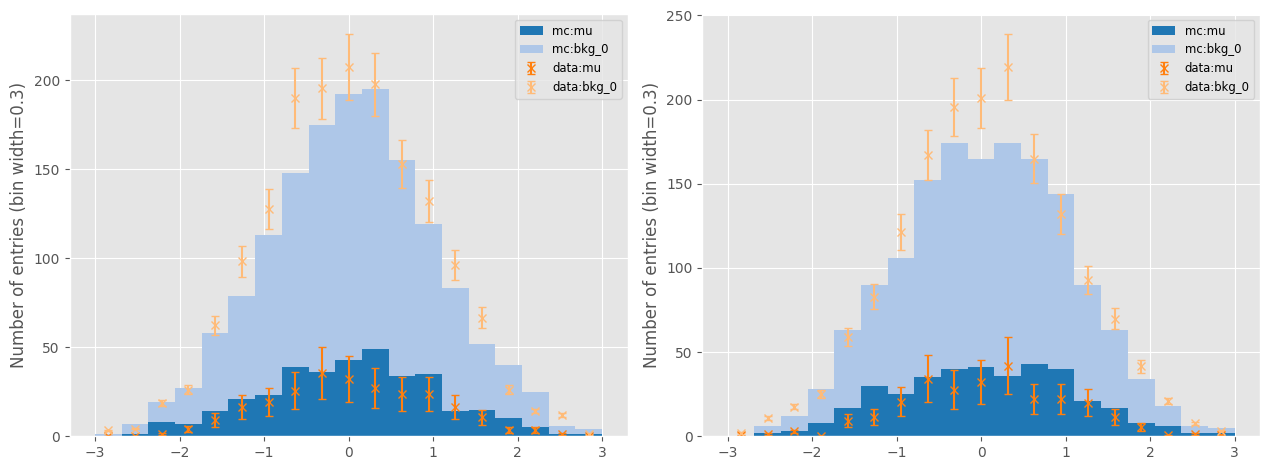

In [ ]:
result = Fit(observations, model)
MakePlots(data, result, n_regions, 1, model)

# multiple backgrounds

400.0

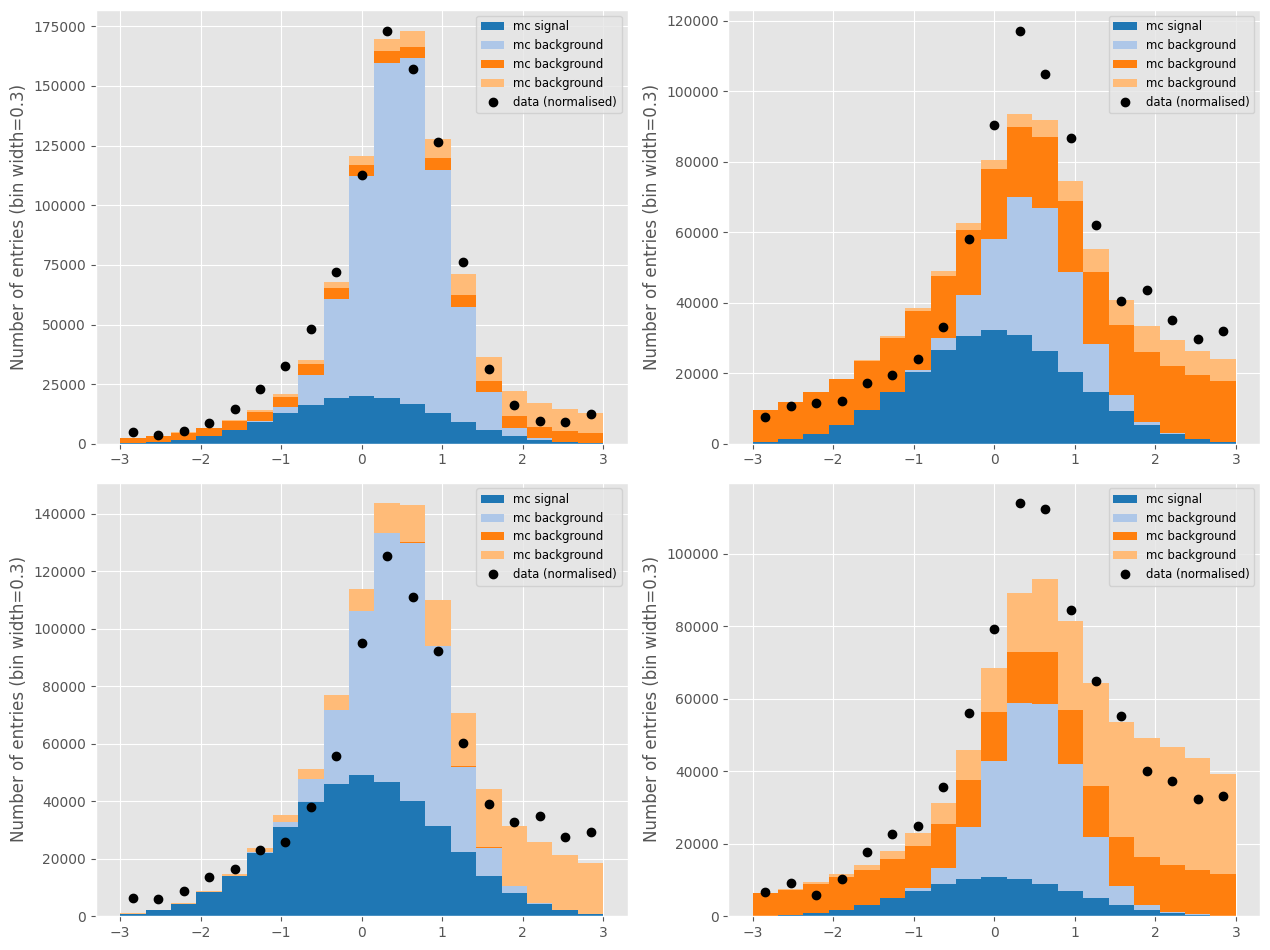

In [101]:
def channel(num : int, signal_data : np.array, background_data : list[np.array]):
    return {
        "name": f"channel_{num}",
        "samples":[
            {
                "name" : "signal",
                "data" : signal_data,
                "modifiers" : [
                    {'name': "mu", 'type': 'normfactor', 'data': None},
                    # {
                    #     "name": "mu_err",
                    #     "type": "normsys",
                    #     "data": {"hi": 0.9, "lo": 1.1},
                    # }
                    # {'name': f"sig_stat_err_{num}", 'type': 'staterror', 'data': np.sqrt(signal_data)}
                    ]
            },
        ]+[
            {
                "name" : f"background_{num}_{b}",
                "data" : background_data[b],
                "modifiers" : [
                    {'name': f"bkg_{b}", 'type': 'normfactor', 'data': None},
                    # {
                    #     "name": f"bkg_err_{b}",
                    #     "type": "normsys",
                    #     "data": {"hi": 0.9, "lo": 1.1},
                    # }
                    # {'name': f"bkg_stat_err_{num}_{b}", 'type': 'staterror', 'data': np.sqrt(background_data[b])}
                    ]
            }
        for b in range(len(background_data))
        ]
    }

bins = np.linspace(-3, 3, 20)
centers = (bins[1:] + bins[:-1])/2

n_regions = 4
n_background = 3
mc = CreateDataSet(12, n_regions, n_background, int(1E6), bins) # make this once

data = CreateDataSet(19, n_regions, n_background, 2500, bins)

normalisation = int(1E6) / 2500
print(normalisation)

for n in Plots.MultiPlot(n_regions):
    Plots.PlotHist(mc[f"region_{n}"], bins = bins, stacked = True, label = ["mc signal"] + ["mc background"] * n_background, newFigure = False)
    Plots.Plot(centers, data[f"region_{n}_combined"] * normalisation, marker = "o", color = "black", linestyle = "", label = "data (normalised)", newFigure = False)

spec = {"channels" : [
    channel(n, mc[f"region_{n}_binned"][0], mc[f"region_{n}_binned"][1:])
    for n in range(n_regions)]}
model = pyhf.Model(spec = spec)


In [102]:
PrintModelSpecs(model)
observations = GenerateObservations(data, n_regions, model)

channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']

nbins: {'channel_0': 19, 'channel_1': 19, 'channel_2': 19, 'channel_3': 19}

samples: ['background_0_0', 'background_0_1', 'background_0_2', 'background_1_0', 'background_1_1', 
'background_1_2', 'background_2_0', 'background_2_1', 'background_2_2', 'background_3_0', 'background_3_1', 
'background_3_2', 'signal']

modifiers: [('bkg_0', 'normfactor'), ('bkg_1', 'normfactor'), ('bkg_2', 'normfactor'), ('mu', 'normfactor')]

parameters: ['bkg_0', 'bkg_1', 'bkg_2', 'mu']

nauxdata: 0

auxdata: []

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]

model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3419188.11358687])

model.config.poi_index=3

result=array([[2.48895108e-03, 6.65210132e-05],
       [2.79246653e-03, 1.21945290e-04],
       [2.44201602e-03, 1.11269223e-04],
       [2.28884771e-03, 1.03342239e-04]])

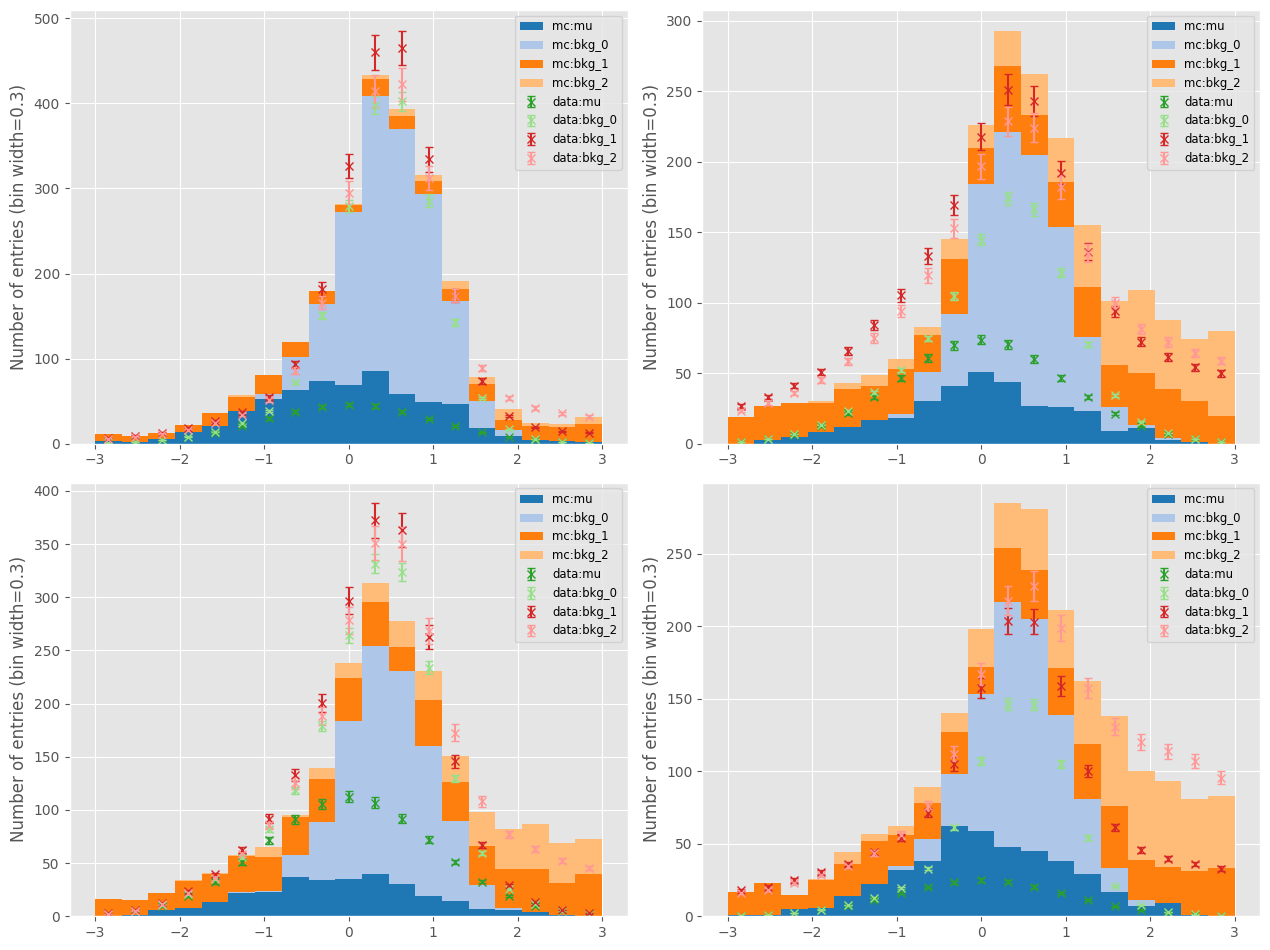

In [103]:
result = Fit(observations, model)
MakePlots(data, result, n_regions, n_background, model)

In [98]:
def CalculatePulls(n_experiments):
    pull = []
    for n in range(n_experiments):
        ex = CreateDataSet(12, n_regions, n_background, 2500, bins)
        observations = GenerateObservations(ex, n_regions, model, verbose = False)
        result = Fit(observations, model, verbose = False)
        pull.append(((normalisation * result[:, 0]) - 1) / (normalisation * result[:, 1]))
    return np.array(pull)

pulls = CalculatePulls(1000)

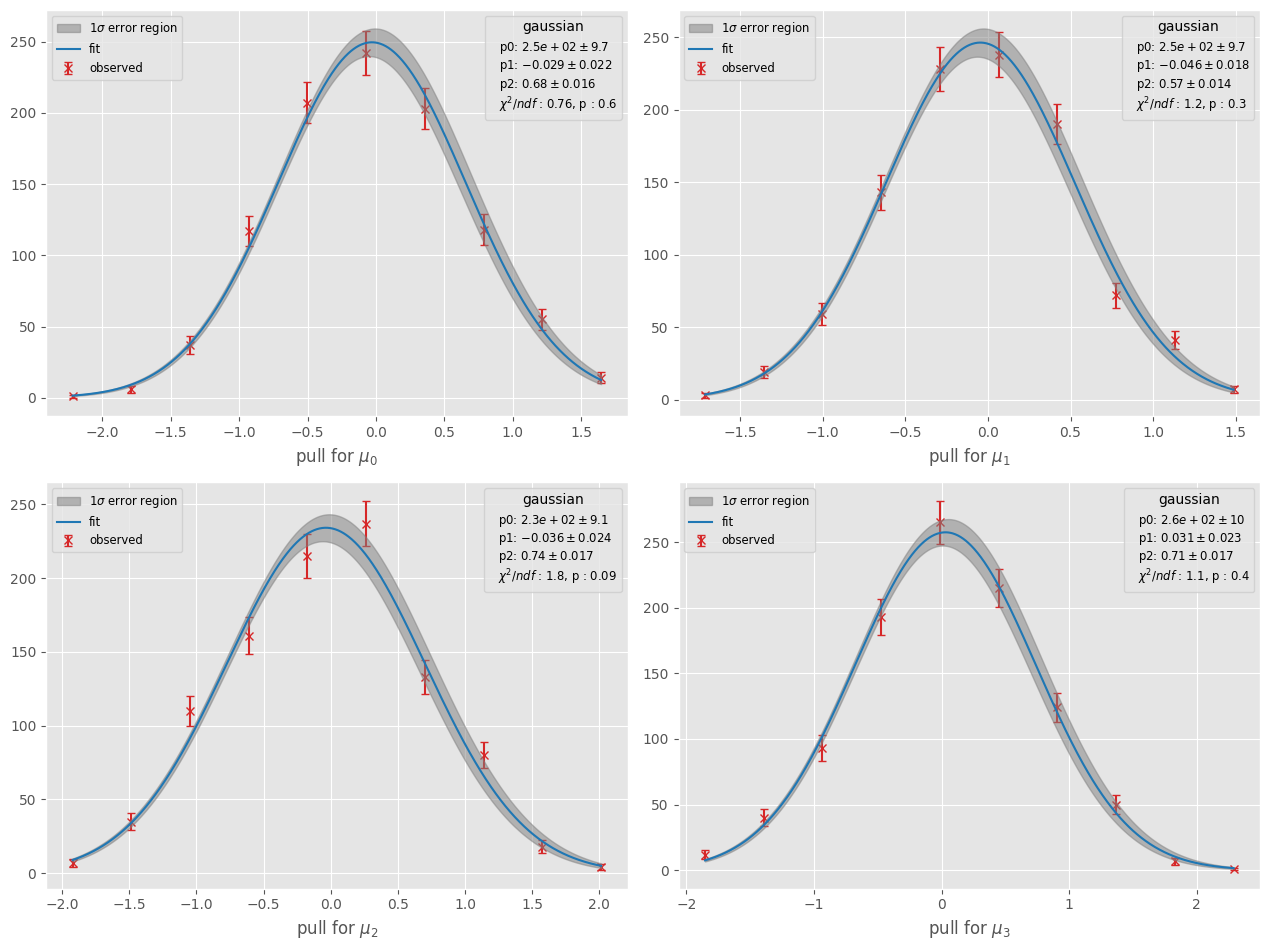

In [99]:
from python.analysis import Fitting
for i in Plots.MultiPlot(4):
    y, x = np.histogram(pulls[:, i], bins = 10)
    x = (x[1:] + x[:-1]) / 2
    # print(f"{np.mean(pulls[:, i])=}")
    # print(f"{np.std(pulls[:, i])=}")
    Fitting.Fit(x, y, np.sqrt(y), Fitting.gaussian, plot = True, method = "trf", xlabel = f"pull for $\mu_{i}$")
    # Plots.PlotHist(pulls[:, i], newFigure = False)

In [5]:
[vars(model.config.param_set(k)) for k in model.config.par_order]

[{'name': 'bkg_0',
  'n_parameters': 1,
  'suggested_init': [1.0],
  'suggested_bounds': [(0, 10)],
  '_suggested_fixed': False,
  'is_scalar': True,
  'constrained': False},
 {'name': 'bkg_1',
  'n_parameters': 1,
  'suggested_init': [1.0],
  'suggested_bounds': [(0, 10)],
  '_suggested_fixed': False,
  'is_scalar': True,
  'constrained': False},
 {'name': 'bkg_2',
  'n_parameters': 1,
  'suggested_init': [1.0],
  'suggested_bounds': [(0, 10)],
  '_suggested_fixed': False,
  'is_scalar': True,
  'constrained': False},
 {'name': 'mu',
  'n_parameters': 1,
  'suggested_init': [1.0],
  'suggested_bounds': [(0, 10)],
  '_suggested_fixed': False,
  'is_scalar': True,
  'constrained': False},
 {'name': 'bkg_err_0',
  'n_parameters': 1,
  'suggested_init': [0.0],
  'suggested_bounds': [(-5.0, 5.0)],
  '_suggested_fixed': False,
  'is_scalar': True,
  'constrained': True,
  'pdf_type': 'normal',
  'auxdata': [0.0]},
 {'name': 'bkg_err_1',
  'n_parameters': 1,
  'suggested_init': [0.0],
  'sug